# Computational modeling : RL algorithms in a virtual environment

Question : under very low amounts of evidence, how do human sample a complex action space ? Can we infer some form of structure in this exploration ? Can Active Inference provide some answers regarding the mechanistic processes behind it ?



First, we grab the data corresponding to the experiment we're interested in (here, experiment 002). We also remove the subjects that either had technical issues or had very suspicious results. *(we should provide a clear rule on subject exclusion here, maybe based on action variance across all dimensions or reaction times ?).*

In [1]:
!pip list

Package                   Version
------------------------- -----------
absl-py                   2.1.0
active_pynference         0.1.44
annotated-types           0.7.0
anyio                     4.8.0
arviz                     0.19.0
asttokens                 2.4.1
attrs                     24.2.0
beautifulsoup4            4.12.3
certifi                   2024.7.4
chardet                   3.0.4
charset-normalizer        3.3.2
chex                      0.1.86
cloudpickle               3.0.0
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.2.1
corner                    2.2.2
cycler                    0.12.1
debugpy                   1.8.2
decorator                 5.1.1
deep-translator           1.11.4
distro                    1.9.0
dm-tree                   0.1.8
dnspython                 2.6.1
etils                     1.9.4
exceptiongroup            1.2.2
executing                 2.0.1
fastjsonschema            2.20.0
fastprogress         

In [2]:

import sys
import pickle 
import os
print(sys.prefix)
# Import the needed packages 
# 
# 1/ the usual suspects
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import jax
import jax.numpy as jnp
from jax import vmap
from jax.tree_util import tree_map
import jax.random as jr
import tensorflow_probability.substrates.jax.distributions as tfd

from functools import partial

import importlib   # To import model files with poorly written names  ¯\_(ツ)_/¯
from tabulate import tabulate # to make pretty tables : 

# 2/ Useful functions from our package :
from actynf.jaxtynf.jax_toolbox import _normalize,_jaxlog
from actynf.jaxtynf.jax_toolbox import random_split_like_tree

# To make nice plots : 
from simulate.plot_trajectory import plot_training

# To extract the data : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from analysis_tools.preprocess import get_preprocessed_data_from_df
from utils import remove_by_indices


# The agent class : 
from simulate.general_agent import Agent

# The simulated environment :
from simulate.generate_observations_full_actions import TrainingEnvironment,simulate_training
from simulate.hmm_weights import behavioural_process # The environment is statically defined by its HMM matrices
from simulate.generate_observations_full_actions import generate_synthetic_data

# The inversion scripts :
from simulate.compute_likelihood_full_actions import compute_predicted_actions,compute_loglikelihood
from simulate.compute_likelihood_full_actions import fit_mle_agent,fit_map_agent
from simulate.invert_model import invert_data_for_single_model,invert_data_for_library_of_models
from simulate.simulate_utils import ind2sub,discretize_normal_pdf

from simulate.plot_trajectory import plot_actions,plot_learnt_transition_matrix


RESULTS_SAVEPATH = os.path.join("results","final_inversions_mle")

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env


c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Simulated environment :

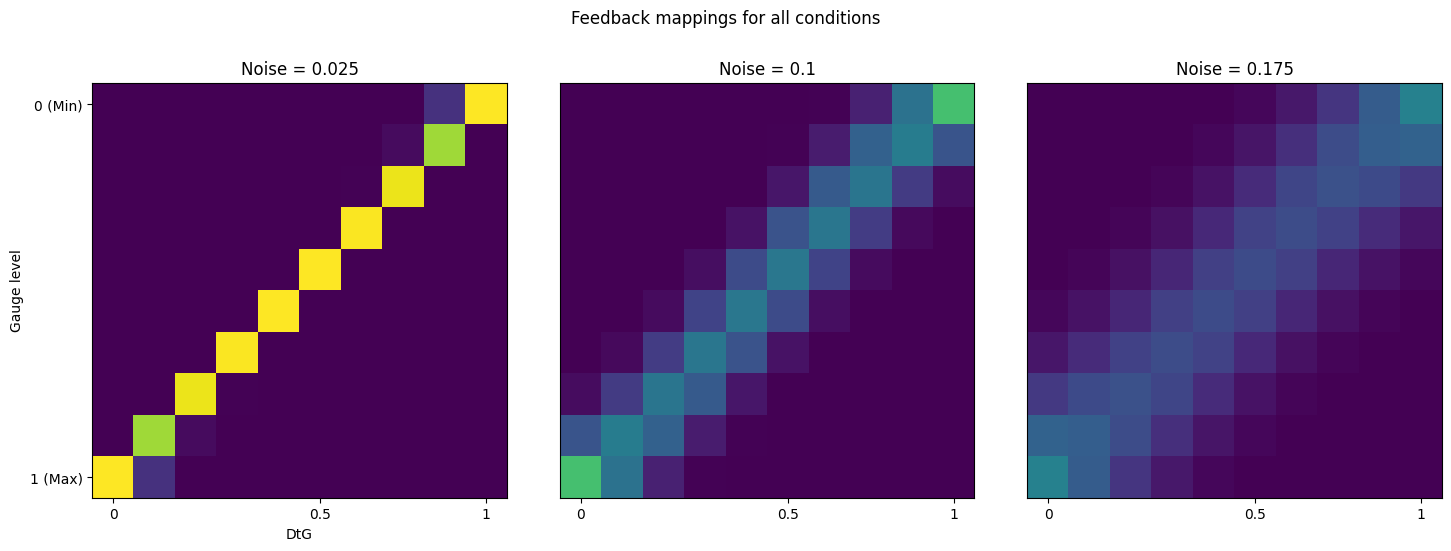

In [3]:
# environment constants :
NTRIALS = 10
T = 11

# MODEL CONSTANTS :
N_LATENT_STATES = 5

# ENVIRONMENTAL CONSTANTS :
N_FEEDBACK_OUTCOMES = 10
TRUE_FEEDBACK_STD =   0.025 #0.175#0.025#0.175#0.025
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]

# The weights of the HMM environment
(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)

rngkey = jax.random.PRNGKey(np.random.randint(0,10))
ENVIRONMENT = TrainingEnvironment(a,b,c,d,e,u,T,NTRIALS)




fig,axs = plt.subplots(1,3,figsize=(15,5))

# Calculate the mean and std of the feedabck and (1- euclidian distance) arrays for each group
noise_value = [0.025,0.1,0.175]
for i,nv in enumerate(noise_value):
    ax = axs[i]
    # Sort distances :
    Npoints = N_FEEDBACK_OUTCOMES
    linear_dist_to_goal = jnp.linspace(0,1,Npoints)
    discretize_distance_normal_function = partial(discretize_normal_pdf,std=nv,num_bins = N_FEEDBACK_OUTCOMES,lower_bound= -1e-5 ,upper_bound = 1.0 + 1e-5)
    a0,edges = vmap(discretize_distance_normal_function,out_axes=-1)(1.0 - linear_dist_to_goal)
    im = ax.imshow(a0,vmin=0.0,vmax=1.0)
    
    ax.set_title("Noise = {}".format(nv))
    if i==0 :
        ax.set_xticks([0,int(Npoints/2),Npoints-1],[0,0.5,1])
        ax.set_yticks([0,N_FEEDBACK_OUTCOMES-1],["0 (Min)","1 (Max)"])
        # ax.set_title("Noisy feedback values \n depending on agent DtG")
        ax.set_xlabel("DtG")
        ax.set_ylabel("Gauge level")
    else :
        ax.set_xticks([0,int(Npoints/2),Npoints-1],[0,0.5,1])
        ax.set_yticks([])
# fig.colorbar(im)      
fig.suptitle('Feedback mappings for all conditions',y=1.05)
fig.tight_layout()

### 2. Defining the inverted models

In [4]:
# define the static dimensions of the problem :
No = N_FEEDBACK_OUTCOMES
Ns = N_LATENT_STATES
MODEL_CONSTANTS = {
    "position" : {
        "N_actions" : 9,
        "N_outcomes" : No,
        "N_states" : Ns,
        "Th" : 2
    },
    "angle" : {
        "N_actions" : 9,
        "N_outcomes" : No,
        "N_states" : Ns,
        "Th" : 2
    },
    "distance" : {
        "N_actions" : 4,
        "N_outcomes" : No,
        "N_states" : Ns,
        "Th" : 2
    },
}

Behaviour of one static biais agent with uniform biais :


Let's initialize a set of parameter ranges and priors for a plethora of models !

## 1. Random model (null hypothesis)



Plotting latent space subject trajectories for the same model :

In [ ]:


model_specs = {
    "model_family" : "random",  # "rw" / "latql" / "tracking_rw"
    "free_parameters" : "independent",
    "biaises" : [],
    "assymetric_learning_rate" : False,
    "modality_selector" : None,
    "generalizer" : False
}       
agent = Agent(model_specs,MODEL_CONSTANTS)
model_hyperparameters = {}
seed = 10



simulated_data = {"feedback":[],"reward":[], "env_state":[]}
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("Example of 9 {} agents simulated training".format(agent.get_name()))
for k,ax in enumerate(axs.reshape(-1)): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)
    
    final_parameters,(environment_variables,agent_variables) = simulate_training(ENVIRONMENT.get_functions(),agent.get_all_functions(model_hyperparameters),
                  jr.PRNGKey(SEED),n_trials=NTRIALS,n_observations_per_trial= ENVIRONMENT.T)
    (_env_states,_env_obs,_env_rewards) = environment_variables
    (_agent_states,_new_params,_agent_actions) = agent_variables

    simulated_states = np.argmax(_env_states,axis=-1)

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)
    
    simulated_data["feedback"].append(_env_obs[0])
    simulated_data["reward"].append(_env_rewards)
    simulated_data["env_state"].append(_env_states)

Ntrials,Ntimesteps,_ =_env_obs[0].shape


obs = np.argmax(np.stack(simulated_data["feedback"]),axis=-1)
scalar_fb = np.reshape(obs/(N_FEEDBACK_OUTCOMES-1),(9,-1))
mean_fb = np.mean(scalar_fb,axis=0)
std_fb = np.std(scalar_fb,axis=0)

gridpoints = jnp.stack(vmap(vmap(vmap(lambda x : ind2sub(GRID_SIZE,x))))(jnp.argmax(jnp.stack(simulated_data["env_state"]),-1)),axis=-1)
maxdist = jnp.linalg.norm(jnp.array(GRID_SIZE))
dtgs = vmap(vmap(vmap(lambda x : jnp.linalg.norm(jnp.array(END_COORD) - x))))(gridpoints)
scalar_dtg = np.reshape(dtgs/maxdist,(9,-1))
mean_dtg = np.mean(scalar_dtg,axis=0)
std_dtg = np.std(scalar_dtg,axis=0)


fig,axs = plt.subplots(2,1,figsize = (6,8),sharex=True)
fig.suptitle("Simulated performances for 9 {} agents".format(agent.get_name()))
axs[0].fill_between(np.arange(mean_fb.shape[0]),mean_fb-std_fb,mean_fb+std_fb,alpha=0.1)
axs[0].plot(np.arange(mean_fb.shape[0]),mean_fb)
for ax in axs:
    ax.set_ylim([0,1])
    ax.grid()
    for trial in range(Ntrials):
        ax.axvline(trial*Ntimesteps,color='red',linestyle="--")
axs[0].set_ylabel("Feedback received")
axs[1].fill_between(np.arange(mean_dtg.shape[0]),mean_dtg-std_dtg,mean_dtg+std_dtg,alpha=0.1)
axs[1].plot(np.arange(mean_dtg.shape[0]),mean_dtg)
for ax in axs:
    for trial in range(Ntrials):
        ax.axvline(trial*Ntimesteps,color='red',linestyle="--")
axs[1].set_xlabel("Trials")
axs[1].set_ylabel("DtG")



# We plot example actions here :
# Because our models are quite simple, we add a little gaussian noise around the sampled values :
Nlines = 2
Ncols = 2
trials =  [0,1,4,9]
fig,axes = plt.subplots(Nlines,Ncols,figsize=(5*Ncols,5*Nlines))
fig.suptitle("Example of the actions performed by a {} agent \nduring {} trials of simulated training".format(agent.get_name(),len(trials)))
# trials = range(axes.flatten().shape[0])
for trial,ax in zip(trials,axes.flatten()):
    ax_title  = ("Trial {}".format(trial+1))
    if trial < Ntrials :
        actions_plotted = {key:val[trial] for (key,val) in _agent_actions.items()}
        plot_actions(ax,actions_plotted,ax_title,'dots')
    else :
        ax.axis('off')
plt.show()


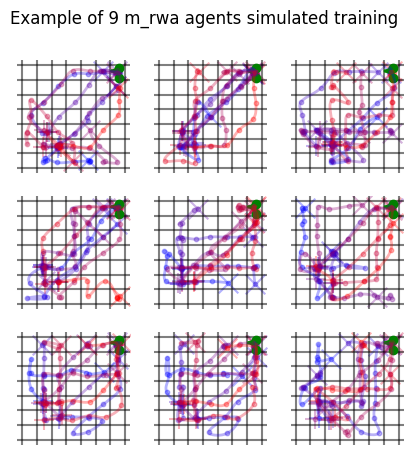

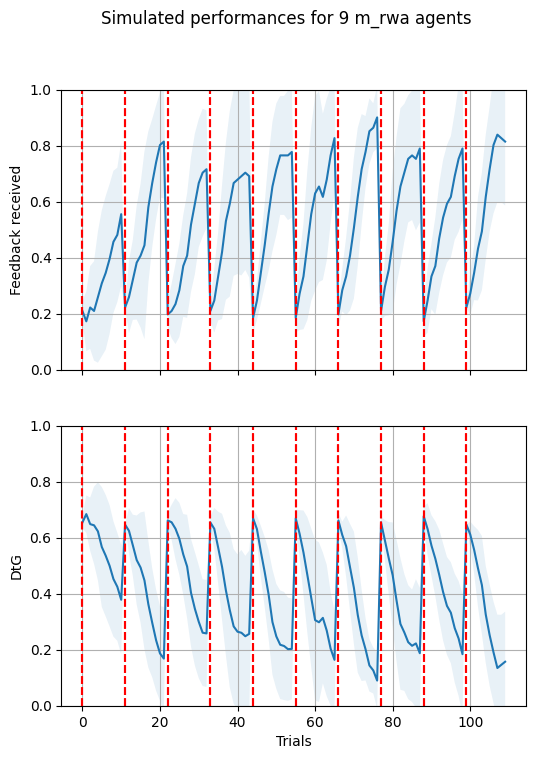

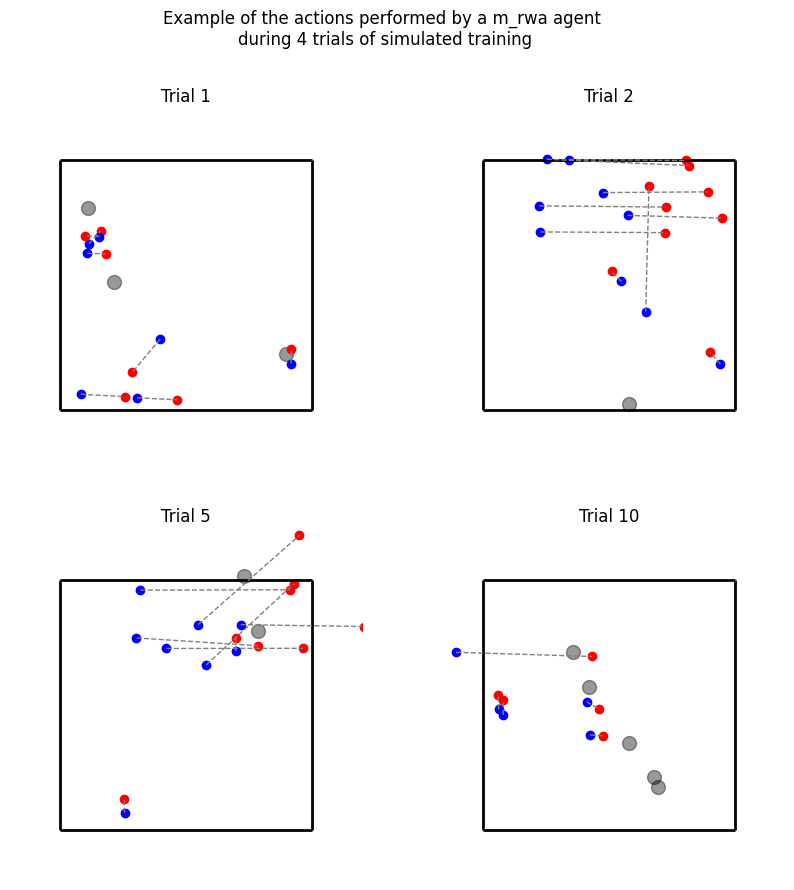

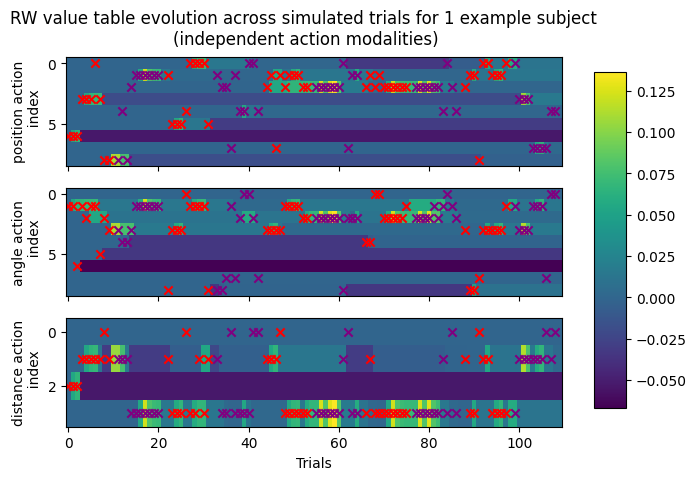

In [ ]:

model_specs = {
    "model_family" : "rw",  # "rw" / "latql" / "tracking_rw"
    "free_parameters" : "mixed",
    "biaises" : [],
    "assymetric_learning_rate" : True,
    "modality_selector" : None,
    "generalizer" : False
}       
agent = Agent(model_specs,MODEL_CONSTANTS)
model_hyperparameters = {
    'alpha_Q+': 0.3, 
    'alpha_Q-': 0.2, 
    'beta_Q': 60.0
}
seed = 10


simulated_data = {"feedback":[],"reward":[], "env_state":[]}
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("Example of 9 {} agents simulated training".format(agent.get_name()))
for k,ax in enumerate(axs.reshape(-1)): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)
    
    final_parameters,(environment_variables,agent_variables) = simulate_training(ENVIRONMENT.get_functions(),agent.get_all_functions(model_hyperparameters),
                  jr.PRNGKey(SEED),n_trials=NTRIALS,n_observations_per_trial= ENVIRONMENT.T)
    (_env_states,_env_obs,_env_rewards) = environment_variables
    (_agent_states,_new_params,_agent_actions) = agent_variables

    simulated_states = np.argmax(_env_states,axis=-1)

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)
    
    simulated_data["feedback"].append(_env_obs[0])
    simulated_data["reward"].append(_env_rewards)
    simulated_data["env_state"].append(_env_states)

Ntrials,Ntimesteps,_ =_env_obs[0].shape


obs = np.argmax(np.stack(simulated_data["feedback"]),axis=-1)
scalar_fb = np.reshape(obs/(N_FEEDBACK_OUTCOMES-1),(9,-1))
mean_fb = np.mean(scalar_fb,axis=0)
std_fb = np.std(scalar_fb,axis=0)

gridpoints = jnp.stack(vmap(vmap(vmap(lambda x : ind2sub(GRID_SIZE,x))))(jnp.argmax(jnp.stack(simulated_data["env_state"]),-1)),axis=-1)
maxdist = jnp.linalg.norm(jnp.array(GRID_SIZE))
dtgs = vmap(vmap(vmap(lambda x : jnp.linalg.norm(jnp.array(END_COORD) - x))))(gridpoints)
scalar_dtg = np.reshape(dtgs/maxdist,(9,-1))
mean_dtg = np.mean(scalar_dtg,axis=0)
std_dtg = np.std(scalar_dtg,axis=0)


fig,axs = plt.subplots(2,1,figsize = (6,8),sharex=True)
fig.suptitle("Simulated performances for 9 {} agents".format(agent.get_name()))
axs[0].fill_between(np.arange(mean_fb.shape[0]),mean_fb-std_fb,mean_fb+std_fb,alpha=0.1)
axs[0].plot(np.arange(mean_fb.shape[0]),mean_fb)
for ax in axs:
    ax.set_ylim([0,1])
    ax.grid()
    for trial in range(Ntrials):
        ax.axvline(trial*Ntimesteps,color='red',linestyle="--")
axs[0].set_ylabel("Feedback received")
axs[1].fill_between(np.arange(mean_dtg.shape[0]),mean_dtg-std_dtg,mean_dtg+std_dtg,alpha=0.1)
axs[1].plot(np.arange(mean_dtg.shape[0]),mean_dtg)
for ax in axs:
    for trial in range(Ntrials):
        ax.axvline(trial*Ntimesteps,color='red',linestyle="--")
axs[1].set_xlabel("Trials")
axs[1].set_ylabel("DtG")



# We plot example actions here :
# Because our models are quite simple, we add a little gaussian noise around the sampled values :
Nlines = 2
Ncols = 2
trials =  [0,1,4,9]
fig,axes = plt.subplots(Nlines,Ncols,figsize=(5*Ncols,5*Nlines))
fig.suptitle("Example of the actions performed by a {} agent \nduring {} trials of simulated training".format(agent.get_name(),len(trials)))
# trials = range(axes.flatten().shape[0])
for trial,ax in zip(trials,axes.flatten()):
    ax_title  = ("Trial {}".format(trial+1))
    if trial < Ntrials :
        actions_plotted = {key:val[trial] for (key,val) in _agent_actions.items()}
        plot_actions(ax,actions_plotted,ax_title,'dots')
    else :
        ax.axis('off')
plt.show()


# We plot the latent states of interest for this model family here : 
vmin = min([np.min(m) for m in _agent_states["q_table"].values()])
vmax = max([np.max(m) for m in _agent_states["q_table"].values()])

fig,axs = plt.subplots(3,1,sharex=True)
fig.suptitle("RW value table evolution across simulated trials for 1 example subject \n(independent action modalities)")
for ax,modality in zip(axs,["position","angle","distance"]) : 
    state_hist = _agent_states["q_table"][modality]
    qtable_state = np.reshape(state_hist,(-1,state_hist.shape[-1]))
    im = ax.imshow(qtable_state.T,aspect=('auto'),vmin = vmin,vmax=vmax)
    ax.set_ylabel("{} action\n  index".format(modality))
    
    
    for trial in range(Ntrials):
        # To differentiate between trials
        if trial % 2 == 0:
            color = 'red'
        else : 
            color = 'purple'
        actions_performed = np.argmax(_agent_actions[modality][trial],axis=-1)
        action_timesteps = Ntimesteps*trial + (np.arange(actions_performed.shape[0]))
        ax.scatter(action_timesteps,actions_performed,marker="x",color=color)
axs[-1].set_xlabel("Trials")
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

We may want to capture some subject's initial tendencies to go prefer or avoid some actions ...

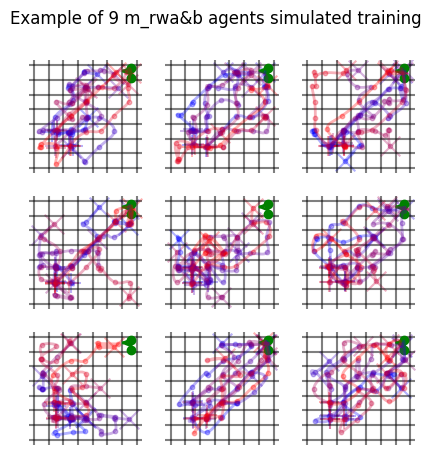

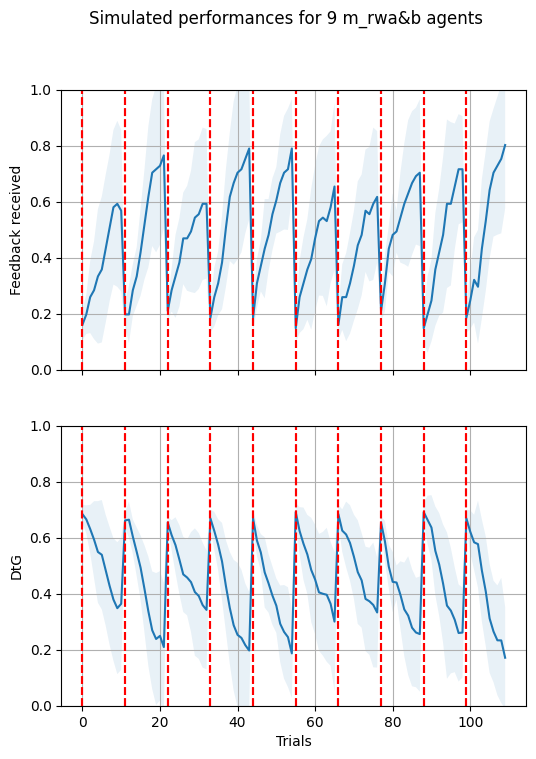

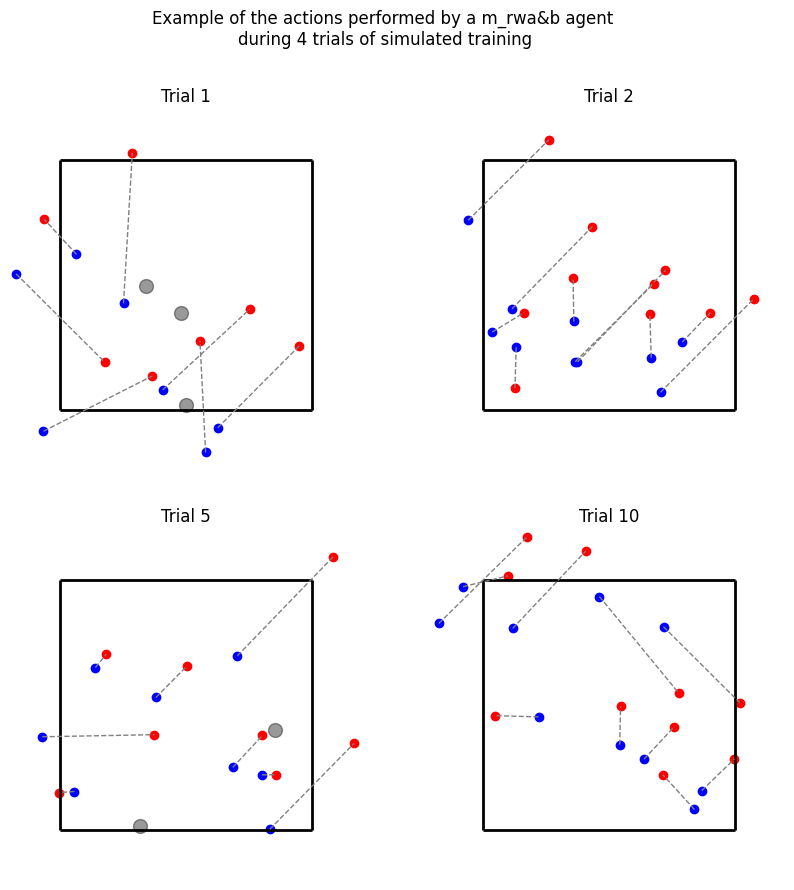

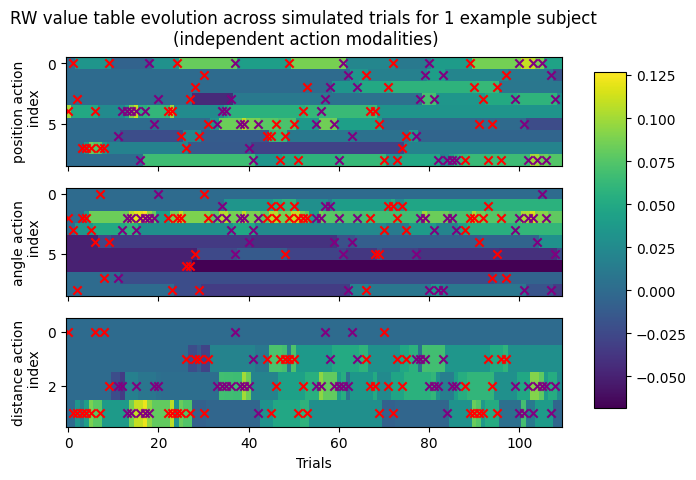

In [ ]:

model_specs = {
    "model_family" : "rw",  # "rw" / "latql" / "tracking_rw"
    "free_parameters" : "mixed",
    "biaises" : ['initial'],
    "assymetric_learning_rate" : True,
    "modality_selector" : None,
    "generalizer" : False
}       
agent = Agent(model_specs,MODEL_CONSTANTS)
model_hyperparameters = {
    'alpha_Q+': 0.3, 
    'alpha_Q-': 0.2, 
    'beta_Q': 20.0,
    'position':{
        'initial_q' : jnp.array([0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0])  # The center of the screen is favorized initially
    },
    'angle':{
        'initial_q' : jnp.array([0.0,0.0,0.0,0.0,-0.05,-0.05,-0.05,0.0,0.0])
    },
    'distance':{
        'initial_q' : jnp.array([0.0,0,0,0])
    },
}
seed = 10


simulated_data = {"feedback":[],"reward":[], "env_state":[]}
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("Example of 9 {} agents simulated training".format(agent.get_name()))
for k,ax in enumerate(axs.reshape(-1)): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)
    
    final_parameters,(environment_variables,agent_variables) = simulate_training(ENVIRONMENT.get_functions(),agent.get_all_functions(model_hyperparameters),
                  jr.PRNGKey(SEED),n_trials=NTRIALS,n_observations_per_trial= ENVIRONMENT.T)
    (_env_states,_env_obs,_env_rewards) = environment_variables
    (_agent_states,_new_params,_agent_actions) = agent_variables

    simulated_states = np.argmax(_env_states,axis=-1)

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)
    
    simulated_data["feedback"].append(_env_obs[0])
    simulated_data["reward"].append(_env_rewards)
    simulated_data["env_state"].append(_env_states)

Ntrials,Ntimesteps,_ =_env_obs[0].shape


obs = np.argmax(np.stack(simulated_data["feedback"]),axis=-1)
scalar_fb = np.reshape(obs/(N_FEEDBACK_OUTCOMES-1),(9,-1))
mean_fb = np.mean(scalar_fb,axis=0)
std_fb = np.std(scalar_fb,axis=0)

gridpoints = jnp.stack(vmap(vmap(vmap(lambda x : ind2sub(GRID_SIZE,x))))(jnp.argmax(jnp.stack(simulated_data["env_state"]),-1)),axis=-1)
maxdist = jnp.linalg.norm(jnp.array(GRID_SIZE))
dtgs = vmap(vmap(vmap(lambda x : jnp.linalg.norm(jnp.array(END_COORD) - x))))(gridpoints)
scalar_dtg = np.reshape(dtgs/maxdist,(9,-1))
mean_dtg = np.mean(scalar_dtg,axis=0)
std_dtg = np.std(scalar_dtg,axis=0)


fig,axs = plt.subplots(2,1,figsize = (6,8),sharex=True)
fig.suptitle("Simulated performances for 9 {} agents".format(agent.get_name()))
axs[0].fill_between(np.arange(mean_fb.shape[0]),mean_fb-std_fb,mean_fb+std_fb,alpha=0.1)
axs[0].plot(np.arange(mean_fb.shape[0]),mean_fb)
for ax in axs:
    ax.set_ylim([0,1])
    ax.grid()
    for trial in range(Ntrials):
        ax.axvline(trial*Ntimesteps,color='red',linestyle="--")
axs[0].set_ylabel("Feedback received")
axs[1].fill_between(np.arange(mean_dtg.shape[0]),mean_dtg-std_dtg,mean_dtg+std_dtg,alpha=0.1)
axs[1].plot(np.arange(mean_dtg.shape[0]),mean_dtg)
for ax in axs:
    for trial in range(Ntrials):
        ax.axvline(trial*Ntimesteps,color='red',linestyle="--")
axs[1].set_xlabel("Trials")
axs[1].set_ylabel("DtG")



# We plot example actions here :
# Because our models are quite simple, we add a little gaussian noise around the sampled values :
Nlines = 2
Ncols = 2
trials =  [0,1,4,9]
fig,axes = plt.subplots(Nlines,Ncols,figsize=(5*Ncols,5*Nlines))
fig.suptitle("Example of the actions performed by a {} agent \nduring {} trials of simulated training".format(agent.get_name(),len(trials)))
# trials = range(axes.flatten().shape[0])
for trial,ax in zip(trials,axes.flatten()):
    ax_title  = ("Trial {}".format(trial+1))
    if trial < Ntrials :
        actions_plotted = {key:val[trial] for (key,val) in _agent_actions.items()}
        plot_actions(ax,actions_plotted,ax_title,'dots')
    else :
        ax.axis('off')
plt.show()


# We plot the latent states of interest for this model family here : 
vmin = min([np.min(m) for m in _agent_states["q_table"].values()])
vmax = max([np.max(m) for m in _agent_states["q_table"].values()])

fig,axs = plt.subplots(3,1,sharex=True)
fig.suptitle("RW value table evolution across simulated trials for 1 example subject \n(independent action modalities)")
for ax,modality in zip(axs,["position","angle","distance"]) : 
    state_hist = _agent_states["q_table"][modality]
    qtable_state = np.reshape(state_hist,(-1,state_hist.shape[-1]))
    im = ax.imshow(qtable_state.T,aspect=('auto'),vmin = vmin,vmax=vmax)
    ax.set_ylabel("{} action\n  index".format(modality))
    
    
    for trial in range(Ntrials):
        # To differentiate between trials
        if trial % 2 == 0:
            color = 'red'
        else : 
            color = 'purple'
        actions_performed = np.argmax(_agent_actions[modality][trial],axis=-1)
        action_timesteps = Ntimesteps*trial + (np.arange(actions_performed.shape[0]))
        ax.scatter(action_timesteps,actions_performed,marker="x",color=color)
axs[-1].set_xlabel("Trials")
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

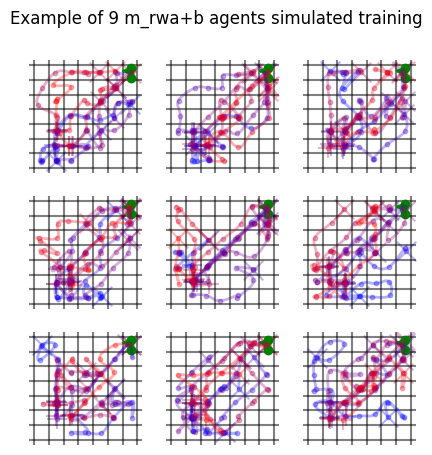

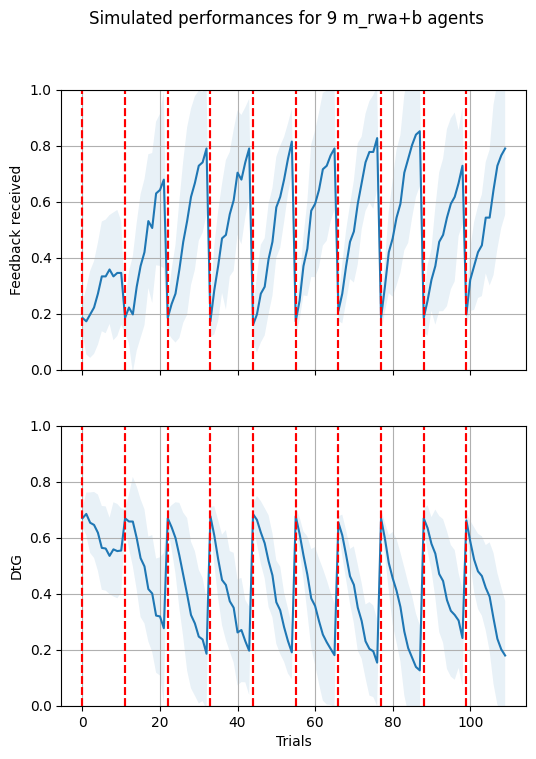

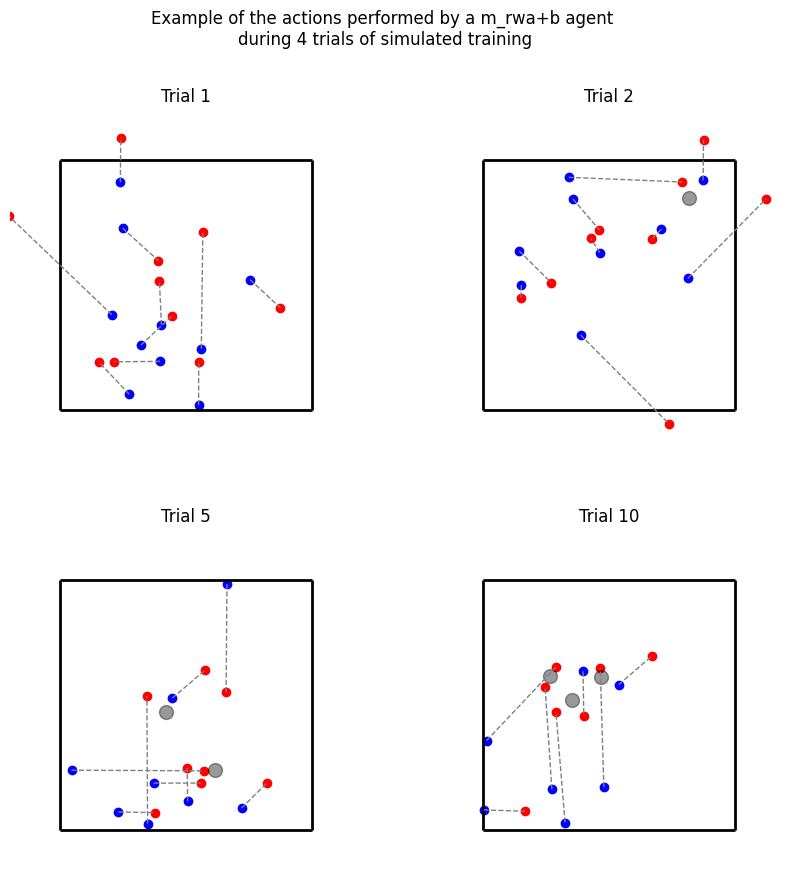

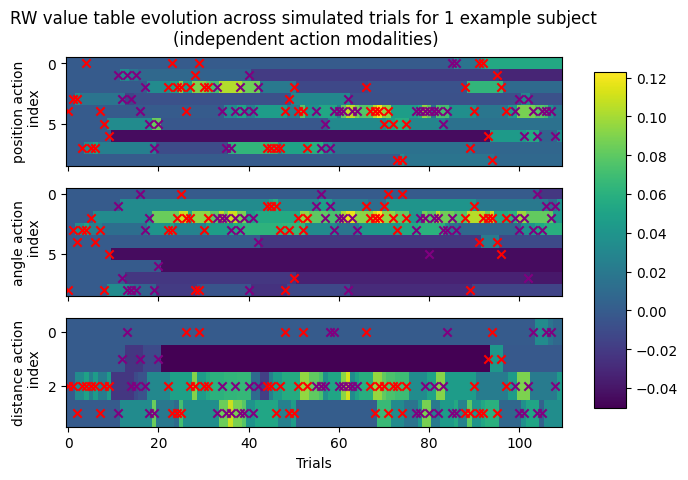

In [ ]:

model_specs = {
    "model_family" : "rw",  # "rw" / "latql" / "tracking_rw"
    "free_parameters" : "mixed",
    "biaises" : ['static'],
    "assymetric_learning_rate" : True,
    "modality_selector" : None,
    "generalizer" : False
}       
agent = Agent(model_specs,MODEL_CONSTANTS)
model_hyperparameters = {
    'alpha_Q+': 0.3, 
    'alpha_Q-': 0.2, 
    'beta_Q': 25.0,
    'beta_biais' : 10.0,
    'position':{
        'biais' : jnp.array([0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0])  # The center of the screen is favorized initially
    },
    'angle':{
        'biais' : jnp.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
    },
    'distance':{
        'biais' : jnp.array([0.0,0,0,0])
    },
}
seed = 10


simulated_data = {"feedback":[],"reward":[], "env_state":[]}
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("Example of 9 {} agents simulated training".format(agent.get_name()))
for k,ax in enumerate(axs.reshape(-1)): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)
    
    final_parameters,(environment_variables,agent_variables) = simulate_training(ENVIRONMENT.get_functions(),agent.get_all_functions(model_hyperparameters),
                  jr.PRNGKey(SEED),n_trials=NTRIALS,n_observations_per_trial= ENVIRONMENT.T)
    (_env_states,_env_obs,_env_rewards) = environment_variables
    (_agent_states,_new_params,_agent_actions) = agent_variables

    simulated_states = np.argmax(_env_states,axis=-1)

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)
    
    simulated_data["feedback"].append(_env_obs[0])
    simulated_data["reward"].append(_env_rewards)
    simulated_data["env_state"].append(_env_states)

Ntrials,Ntimesteps,_ =_env_obs[0].shape


obs = np.argmax(np.stack(simulated_data["feedback"]),axis=-1)
scalar_fb = np.reshape(obs/(N_FEEDBACK_OUTCOMES-1),(9,-1))
mean_fb = np.mean(scalar_fb,axis=0)
std_fb = np.std(scalar_fb,axis=0)

gridpoints = jnp.stack(vmap(vmap(vmap(lambda x : ind2sub(GRID_SIZE,x))))(jnp.argmax(jnp.stack(simulated_data["env_state"]),-1)),axis=-1)
maxdist = jnp.linalg.norm(jnp.array(GRID_SIZE))
dtgs = vmap(vmap(vmap(lambda x : jnp.linalg.norm(jnp.array(END_COORD) - x))))(gridpoints)
scalar_dtg = np.reshape(dtgs/maxdist,(9,-1))
mean_dtg = np.mean(scalar_dtg,axis=0)
std_dtg = np.std(scalar_dtg,axis=0)


fig,axs = plt.subplots(2,1,figsize = (6,8),sharex=True)
fig.suptitle("Simulated performances for 9 {} agents".format(agent.get_name()))
axs[0].fill_between(np.arange(mean_fb.shape[0]),mean_fb-std_fb,mean_fb+std_fb,alpha=0.1)
axs[0].plot(np.arange(mean_fb.shape[0]),mean_fb)
for ax in axs:
    ax.set_ylim([0,1])
    ax.grid()
    for trial in range(Ntrials):
        ax.axvline(trial*Ntimesteps,color='red',linestyle="--")
axs[0].set_ylabel("Feedback received")
axs[1].fill_between(np.arange(mean_dtg.shape[0]),mean_dtg-std_dtg,mean_dtg+std_dtg,alpha=0.1)
axs[1].plot(np.arange(mean_dtg.shape[0]),mean_dtg)
for ax in axs:
    for trial in range(Ntrials):
        ax.axvline(trial*Ntimesteps,color='red',linestyle="--")
axs[1].set_xlabel("Trials")
axs[1].set_ylabel("DtG")



# We plot example actions here :
# Because our models are quite simple, we add a little gaussian noise around the sampled values :
Nlines = 2
Ncols = 2
trials =  [0,1,4,9]
fig,axes = plt.subplots(Nlines,Ncols,figsize=(5*Ncols,5*Nlines))
fig.suptitle("Example of the actions performed by a {} agent \nduring {} trials of simulated training".format(agent.get_name(),len(trials)))
# trials = range(axes.flatten().shape[0])
for trial,ax in zip(trials,axes.flatten()):
    ax_title  = ("Trial {}".format(trial+1))
    if trial < Ntrials :
        actions_plotted = {key:val[trial] for (key,val) in _agent_actions.items()}
        plot_actions(ax,actions_plotted,ax_title,'dots')
    else :
        ax.axis('off')
plt.show()


# We plot the latent states of interest for this model family here : 
vmin = min([np.min(m) for m in _agent_states["q_table"].values()])
vmax = max([np.max(m) for m in _agent_states["q_table"].values()])

fig,axs = plt.subplots(3,1,sharex=True)
fig.suptitle("RW value table evolution across simulated trials for 1 example subject \n(independent action modalities)")
for ax,modality in zip(axs,["position","angle","distance"]) : 
    state_hist = _agent_states["q_table"][modality]
    qtable_state = np.reshape(state_hist,(-1,state_hist.shape[-1]))
    im = ax.imshow(qtable_state.T,aspect=('auto'),vmin = vmin,vmax=vmax)
    ax.set_ylabel("{} action\n  index".format(modality))
    
    
    for trial in range(Ntrials):
        # To differentiate between trials
        if trial % 2 == 0:
            color = 'red'
        else : 
            color = 'purple'
        actions_performed = np.argmax(_agent_actions[modality][trial],axis=-1)
        action_timesteps = Ntimesteps*trial + (np.arange(actions_performed.shape[0]))
        ax.scatter(action_timesteps,actions_performed,marker="x",color=color)
axs[-1].set_xlabel("Trials")
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

Up until now, we have always assumed that the action models were independent. However, we may complexify the model by assuming that the agent needs to 'focus' its attention on a specific modality. This is an attempt to capture the agent attentional and hypothesis testing mechanisms :

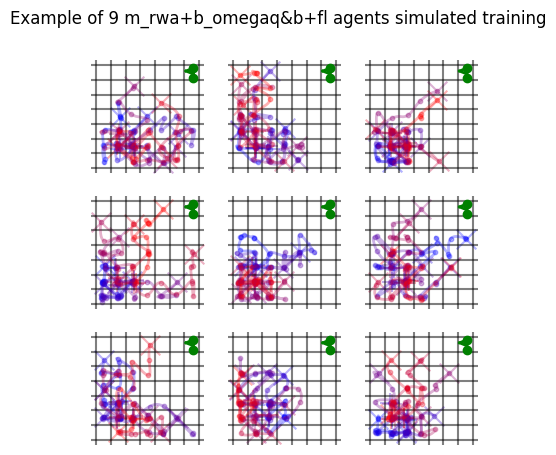

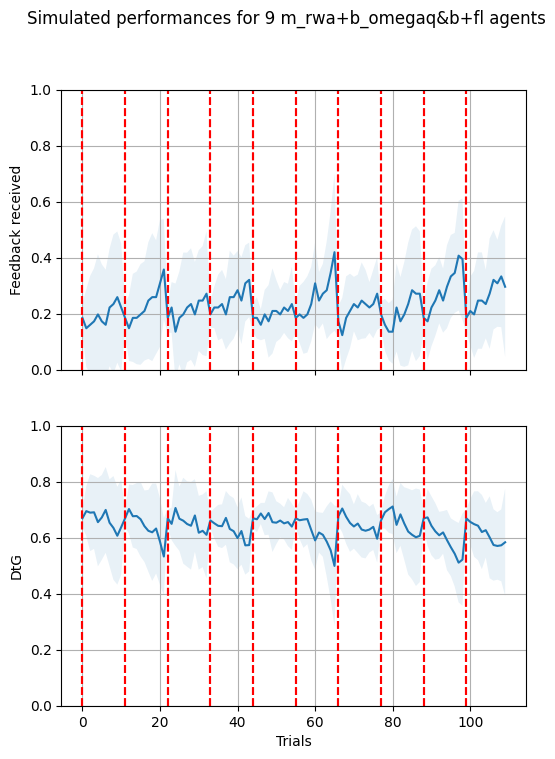

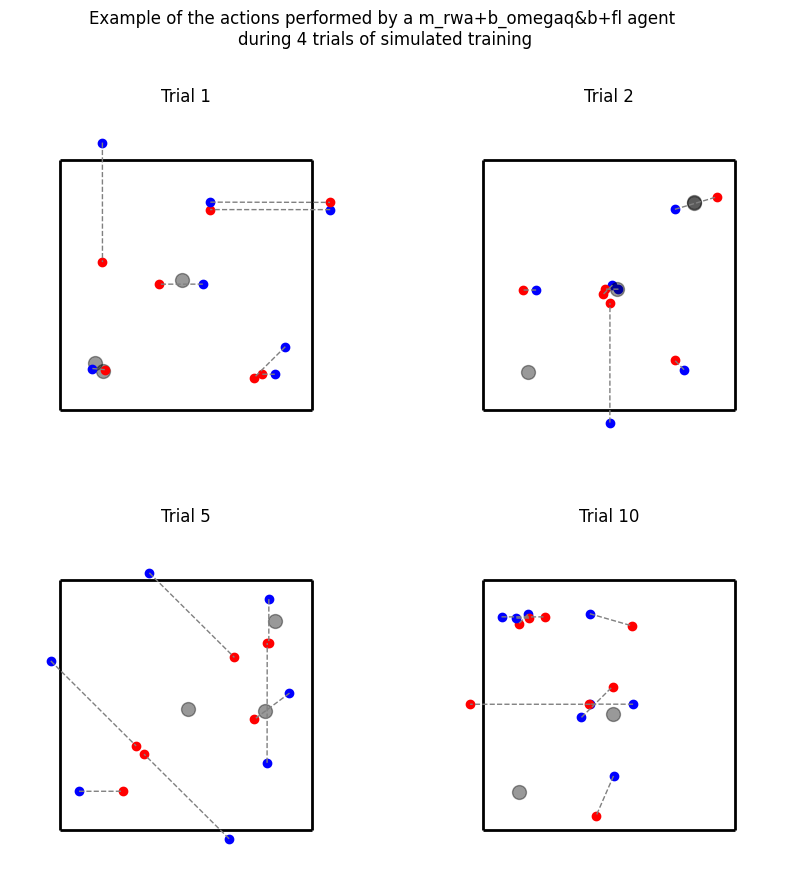

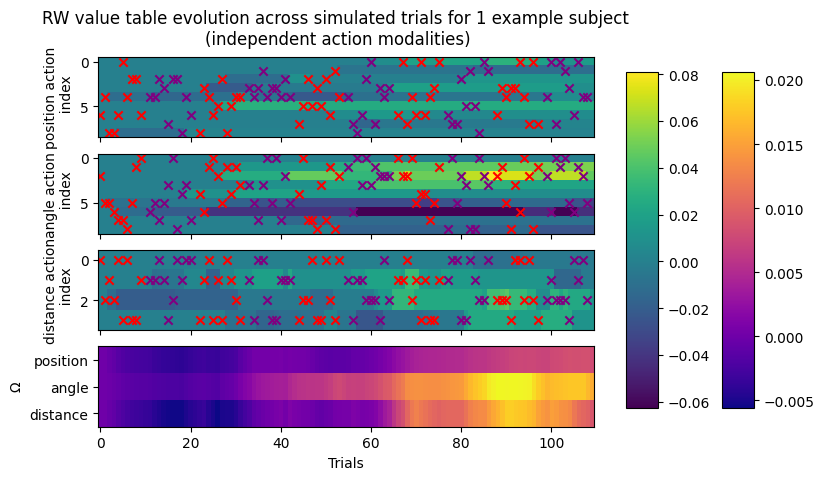

In [ ]:

model_specs = {
    "model_family" : "rw",  # "rw" / "latql" / "tracking_rw"
    "free_parameters" : "mixed",
    "biaises" : ['static'],
    "assymetric_learning_rate" : True,
    "modality_selector" : {
        'learn':True,
        'metric':'q_value',
        'biaises' : ['initial'],
        'focused_learning' : True,
        'independent_focused_learning_weights' : False
    },
    "generalizer" : False
}       
agent = Agent(model_specs,MODEL_CONSTANTS)
model_hyperparameters = {
    'initial_omega' : jnp.array([0.0,0.0,0.0]),
    'alpha_omega' : 0.2,
    'beta_omega' : 100,
    
    'alpha_Q+': 0.3,
    'alpha_Q-': 0.3, 
    'beta_Q': 10.0,
    'beta_biais' : 10.0,
    'position':{
        'biais' : jnp.array([0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0])  # The center of the screen is favorized initially
    },
    'angle':{
        'biais' : jnp.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
    },
    'distance':{
        'biais' : jnp.array([0.0,0,0,0])
    },
}  
agent = Agent(model_specs,MODEL_CONSTANTS)
seed = 10


simulated_data = {"feedback":[],"reward":[], "env_state":[]}
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("Example of 9 {} agents simulated training".format(agent.get_name()))
for k,ax in enumerate(axs.reshape(-1)): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)
    
    final_parameters,(environment_variables,agent_variables) = simulate_training(ENVIRONMENT.get_functions(),agent.get_all_functions(model_hyperparameters),
                  jr.PRNGKey(SEED),n_trials=NTRIALS,n_observations_per_trial= ENVIRONMENT.T)
    (_env_states,_env_obs,_env_rewards) = environment_variables
    (_agent_states,_new_params,_agent_actions) = agent_variables

    simulated_states = np.argmax(_env_states,axis=-1)

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)
    
    simulated_data["feedback"].append(_env_obs[0])
    simulated_data["reward"].append(_env_rewards)
    simulated_data["env_state"].append(_env_states)

Ntrials,Ntimesteps,_ =_env_obs[0].shape


obs = np.argmax(np.stack(simulated_data["feedback"]),axis=-1)
scalar_fb = np.reshape(obs/(N_FEEDBACK_OUTCOMES-1),(9,-1))
mean_fb = np.mean(scalar_fb,axis=0)
std_fb = np.std(scalar_fb,axis=0)

gridpoints = jnp.stack(vmap(vmap(vmap(lambda x : ind2sub(GRID_SIZE,x))))(jnp.argmax(jnp.stack(simulated_data["env_state"]),-1)),axis=-1)
maxdist = jnp.linalg.norm(jnp.array(GRID_SIZE))
dtgs = vmap(vmap(vmap(lambda x : jnp.linalg.norm(jnp.array(END_COORD) - x))))(gridpoints)
scalar_dtg = np.reshape(dtgs/maxdist,(9,-1))
mean_dtg = np.mean(scalar_dtg,axis=0)
std_dtg = np.std(scalar_dtg,axis=0)


fig,axs = plt.subplots(2,1,figsize = (6,8),sharex=True)
fig.suptitle("Simulated performances for 9 {} agents".format(agent.get_name()))
axs[0].fill_between(np.arange(mean_fb.shape[0]),mean_fb-std_fb,mean_fb+std_fb,alpha=0.1)
axs[0].plot(np.arange(mean_fb.shape[0]),mean_fb)
for ax in axs:
    ax.set_ylim([0,1])
    ax.grid()
    for trial in range(Ntrials):
        ax.axvline(trial*Ntimesteps,color='red',linestyle="--")
axs[0].set_ylabel("Feedback received")
axs[1].fill_between(np.arange(mean_dtg.shape[0]),mean_dtg-std_dtg,mean_dtg+std_dtg,alpha=0.1)
axs[1].plot(np.arange(mean_dtg.shape[0]),mean_dtg)
for ax in axs:
    for trial in range(Ntrials):
        ax.axvline(trial*Ntimesteps,color='red',linestyle="--")
axs[1].set_xlabel("Trials")
axs[1].set_ylabel("DtG")



# We plot example actions here :
# Because our models are quite simple, we add a little gaussian noise around the sampled values :
Nlines = 2
Ncols = 2
trials =  [0,1,4,9]
fig,axes = plt.subplots(Nlines,Ncols,figsize=(5*Ncols,5*Nlines))
fig.suptitle("Example of the actions performed by a {} agent \nduring {} trials of simulated training".format(agent.get_name(),len(trials)))
# trials = range(axes.flatten().shape[0])
for trial,ax in zip(trials,axes.flatten()):
    ax_title  = ("Trial {}".format(trial+1))
    if trial < Ntrials :
        actions_plotted = {key:val[trial] for (key,val) in _agent_actions.items()}
        plot_actions(ax,actions_plotted,ax_title,'dots',1e-3)
    else :
        ax.axis('off')
plt.show()


# We plot the latent states of interest for this model family here : 
vmin = min([np.min(m) for m in _agent_states["q_table"].values()])
vmax = max([np.max(m) for m in _agent_states["q_table"].values()])

fig,axs = plt.subplots(4,1,sharex=True)
fig.suptitle("RW value table evolution across simulated trials for 1 example subject \n(independent action modalities)")
for k,modality in enumerate(["position","angle","distance"]) : 
    ax = axs[k]
    state_hist = _agent_states["q_table"][modality]
    qtable_state = np.reshape(state_hist,(-1,state_hist.shape[-1]))
    im = ax.imshow(qtable_state.T,aspect=('auto'),vmin = vmin,vmax=vmax)
    ax.set_ylabel("{} action\n  index".format(modality))
    
    
    for trial in range(Ntrials):
        # To differentiate between trials
        if trial % 2 == 0:
            color = 'red'
        else : 
            color = 'purple'
        actions_performed = np.argmax(_agent_actions[modality][trial],axis=-1)
        action_timesteps = Ntimesteps*trial + (np.arange(actions_performed.shape[0]))
        ax.scatter(action_timesteps,actions_performed,marker="x",color=color)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

# fig,ax = plt.subplots(1,1)
# fig.suptitle("RW modality selection table evolution across simulated trials for 1 example subject \n(independent action modalities)")
im2 = axs[-1].imshow(np.reshape(_agent_states['omega'],(-1,3)).T,aspect=('auto'),cmap='plasma')
axs[-1].set_ylabel("$\Omega$")
axs[-1].set_yticks([0,1,2],["position","angle","distance"])


axs[-1].set_xlabel("Trials")
cbar_ax2 = fig.add_axes([1.1, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax2)
plt.show()

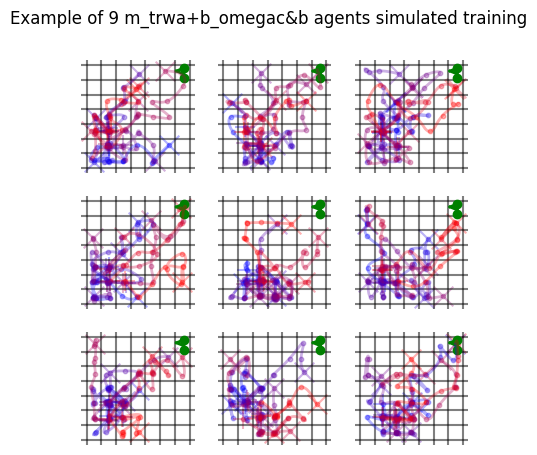

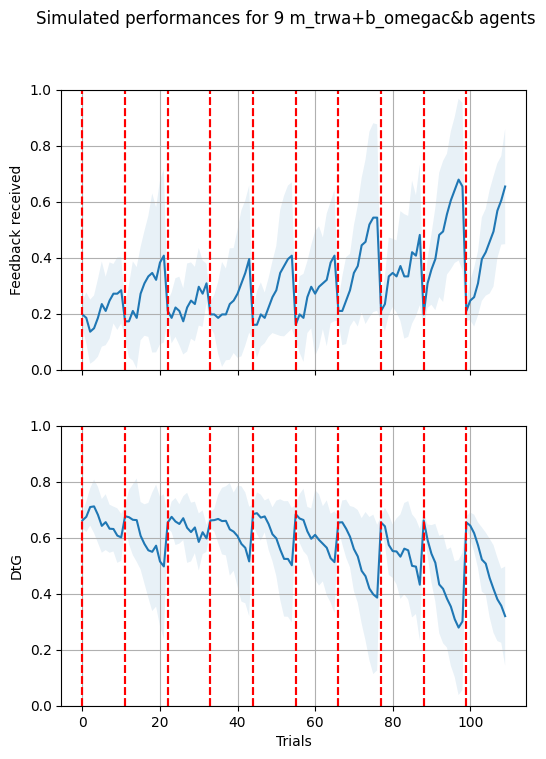

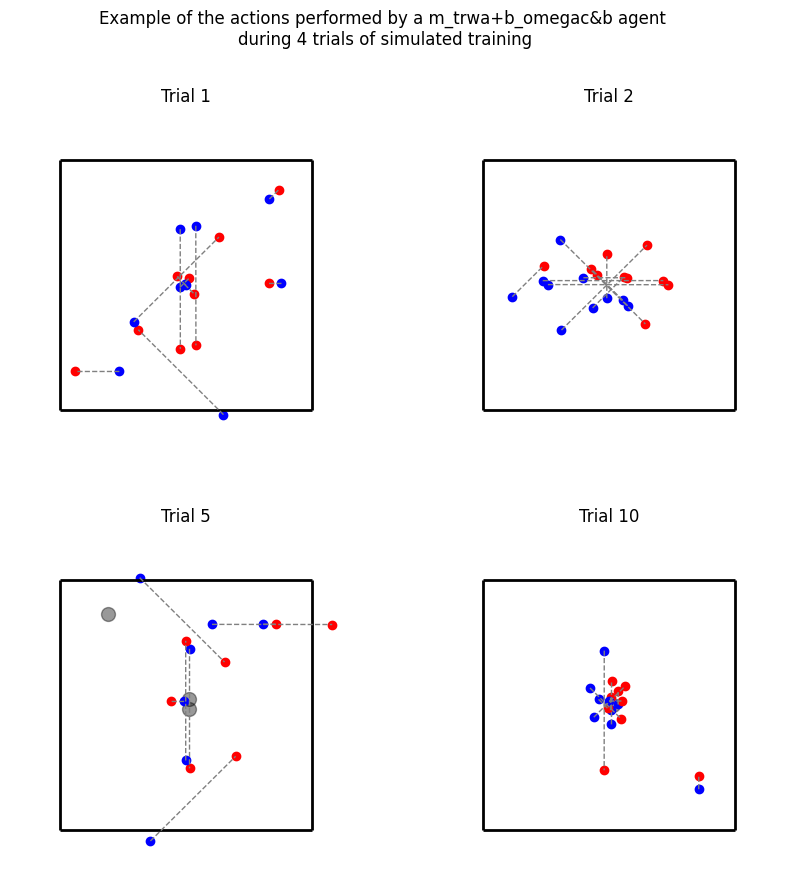

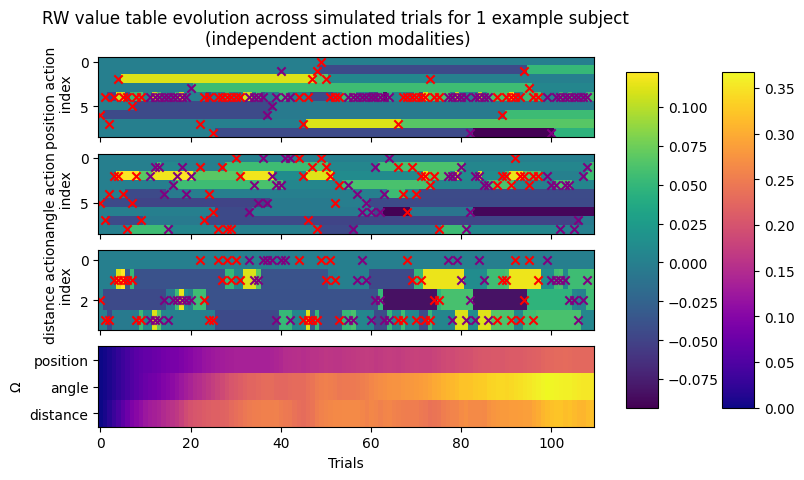

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\simulate\plot_trajectory.py:210: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


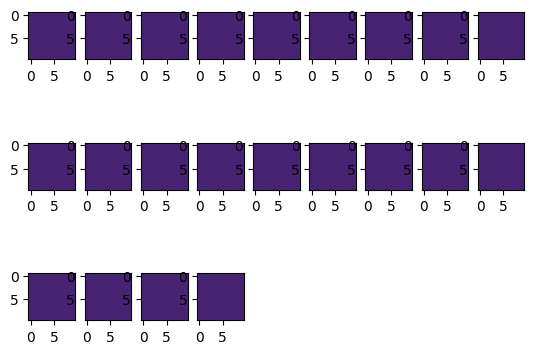

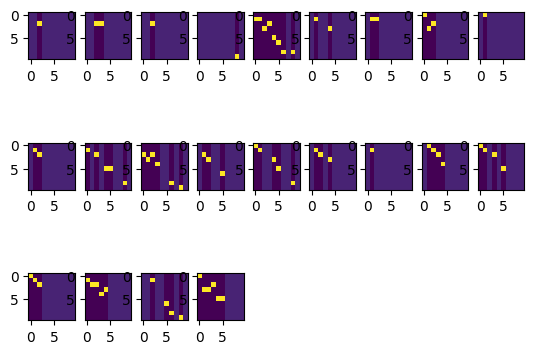

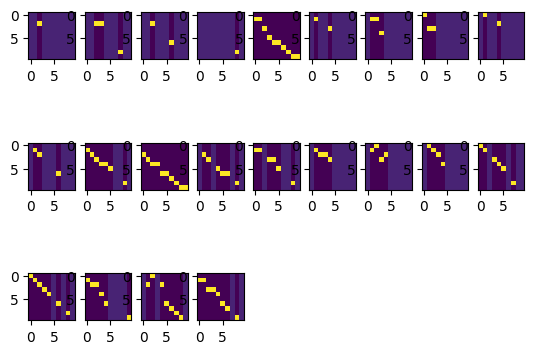

In [ ]:

model_specs = {
    "model_family" : "trw",  # "rw" / "latql" / "tracking_rw"
    "free_parameters" : "mixed",
    "biaises" : ['static'],
    "assymetric_learning_rate" : True,
    "modality_selector" : {
        'learn':True,
        'metric':'js_controll',
        'biaises' : ['initial'],
        'focused_learning' : False,
        'independent_focused_learning_weights' : True
    },
    "generalizer" : False
}       
agent = Agent(model_specs,MODEL_CONSTANTS)
model_hyperparameters = {
    'initial_omega' : jnp.array([0.0,0.0,0.0]),
    'alpha_omega' : 0.4,
    'beta_omega' : 50,
    
    'alpha_Q+': 0.5,
    'alpha_Q-': 0.4, 
    'beta_Q': 30.0,
    'beta_biais' : 30.0,
    'transition_alpha' : 1.0,
    'position':{
        'biais' : jnp.array([0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0])  # The center of the screen is favorized initially
    },
    'angle':{
        'biais' : jnp.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
    },
    'distance':{
        'biais' : jnp.array([0.0,0,0,0])
    },
}  
agent = Agent(model_specs,MODEL_CONSTANTS)
seed = 10


simulated_data = {"feedback":[],"reward":[], "env_state":[]}
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("Example of 9 {} agents simulated training".format(agent.get_name()))
for k,ax in enumerate(axs.reshape(-1)): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)
    
    final_parameters,(environment_variables,agent_variables) = simulate_training(ENVIRONMENT.get_functions(),agent.get_all_functions(model_hyperparameters),
                  jr.PRNGKey(SEED),n_trials=NTRIALS,n_observations_per_trial= ENVIRONMENT.T)
    (_env_states,_env_obs,_env_rewards) = environment_variables
    (_agent_states,_new_params,_agent_actions) = agent_variables

    simulated_states = np.argmax(_env_states,axis=-1)

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)
    
    simulated_data["feedback"].append(_env_obs[0])
    simulated_data["reward"].append(_env_rewards)
    simulated_data["env_state"].append(_env_states)

Ntrials,Ntimesteps,_ =_env_obs[0].shape


obs = np.argmax(np.stack(simulated_data["feedback"]),axis=-1)
scalar_fb = np.reshape(obs/(N_FEEDBACK_OUTCOMES-1),(9,-1))
mean_fb = np.mean(scalar_fb,axis=0)
std_fb = np.std(scalar_fb,axis=0)

gridpoints = jnp.stack(vmap(vmap(vmap(lambda x : ind2sub(GRID_SIZE,x))))(jnp.argmax(jnp.stack(simulated_data["env_state"]),-1)),axis=-1)
maxdist = jnp.linalg.norm(jnp.array(GRID_SIZE))
dtgs = vmap(vmap(vmap(lambda x : jnp.linalg.norm(jnp.array(END_COORD) - x))))(gridpoints)
scalar_dtg = np.reshape(dtgs/maxdist,(9,-1))
mean_dtg = np.mean(scalar_dtg,axis=0)
std_dtg = np.std(scalar_dtg,axis=0)


fig,axs = plt.subplots(2,1,figsize = (6,8),sharex=True)
fig.suptitle("Simulated performances for 9 {} agents".format(agent.get_name()))
axs[0].fill_between(np.arange(mean_fb.shape[0]),mean_fb-std_fb,mean_fb+std_fb,alpha=0.1)
axs[0].plot(np.arange(mean_fb.shape[0]),mean_fb)
for ax in axs:
    ax.set_ylim([0,1])
    ax.grid()
    for trial in range(Ntrials):
        ax.axvline(trial*Ntimesteps,color='red',linestyle="--")
axs[0].set_ylabel("Feedback received")
axs[1].fill_between(np.arange(mean_dtg.shape[0]),mean_dtg-std_dtg,mean_dtg+std_dtg,alpha=0.1)
axs[1].plot(np.arange(mean_dtg.shape[0]),mean_dtg)
for ax in axs:
    for trial in range(Ntrials):
        ax.axvline(trial*Ntimesteps,color='red',linestyle="--")
axs[1].set_xlabel("Trials")
axs[1].set_ylabel("DtG")



# We plot example actions here :
# Because our models are quite simple, we add a little gaussian noise around the sampled values :
Nlines = 2
Ncols = 2
trials =  [0,1,4,9]
fig,axes = plt.subplots(Nlines,Ncols,figsize=(5*Ncols,5*Nlines))
fig.suptitle("Example of the actions performed by a {} agent \nduring {} trials of simulated training".format(agent.get_name(),len(trials)))
# trials = range(axes.flatten().shape[0])
for trial,ax in zip(trials,axes.flatten()):
    ax_title  = ("Trial {}".format(trial+1))
    if trial < Ntrials :
        actions_plotted = {key:val[trial] for (key,val) in _agent_actions.items()}
        plot_actions(ax,actions_plotted,ax_title,'dots',1e-3)
    else :
        ax.axis('off')
plt.show()


# We plot the latent states of interest for this model family here : 
vmin = min([np.min(m) for m in _agent_states["q_table"].values()])
vmax = max([np.max(m) for m in _agent_states["q_table"].values()])

fig,axs = plt.subplots(4,1,sharex=True)
fig.suptitle("RW value table evolution across simulated trials for 1 example subject \n(independent action modalities)")
for k,modality in enumerate(["position","angle","distance"]) : 
    ax = axs[k]
    state_hist = _agent_states["q_table"][modality]
    qtable_state = np.reshape(state_hist,(-1,state_hist.shape[-1]))
    im = ax.imshow(qtable_state.T,aspect=('auto'),vmin = vmin,vmax=vmax)
    ax.set_ylabel("{} action\n  index".format(modality))
    
    
    for trial in range(Ntrials):
        # To differentiate between trials
        if trial % 2 == 0:
            color = 'red'
        else : 
            color = 'purple'
        actions_performed = np.argmax(_agent_actions[modality][trial],axis=-1)
        action_timesteps = Ntimesteps*trial + (np.arange(actions_performed.shape[0]))
        ax.scatter(action_timesteps,actions_performed,marker="x",color=color)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

# fig,ax = plt.subplots(1,1)
# fig.suptitle("RW modality selection table evolution across simulated trials for 1 example subject \n(independent action modalities)")
im2 = axs[-1].imshow(np.reshape(_agent_states['omega'],(-1,3)).T,aspect=('auto'),cmap='plasma')
axs[-1].set_ylabel("$\Omega$")
axs[-1].set_yticks([0,1,2],["position","angle","distance"])


axs[-1].set_xlabel("Trials")
cbar_ax2 = fig.add_axes([1.1, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax2)
plt.show()

for trial in [0,5,9]:
    plot_learnt_transition_matrix(_agent_states,trial,0)

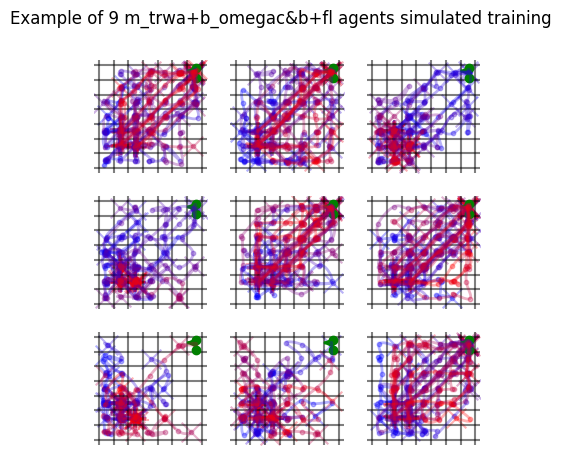

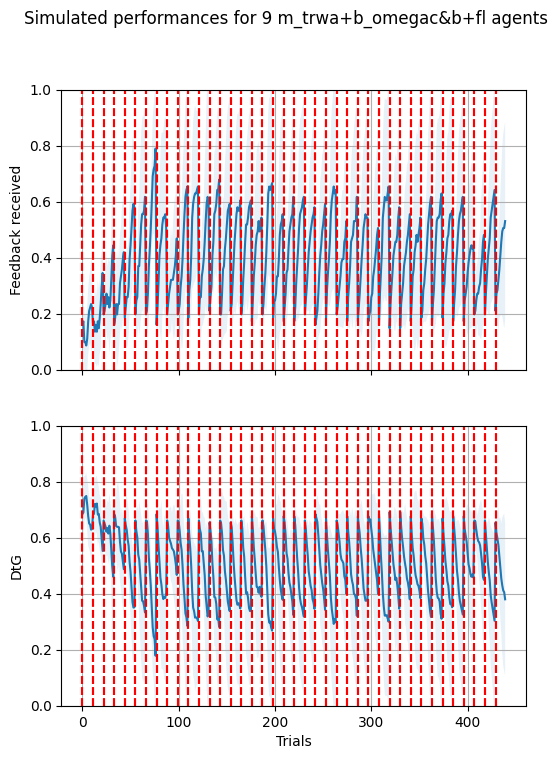

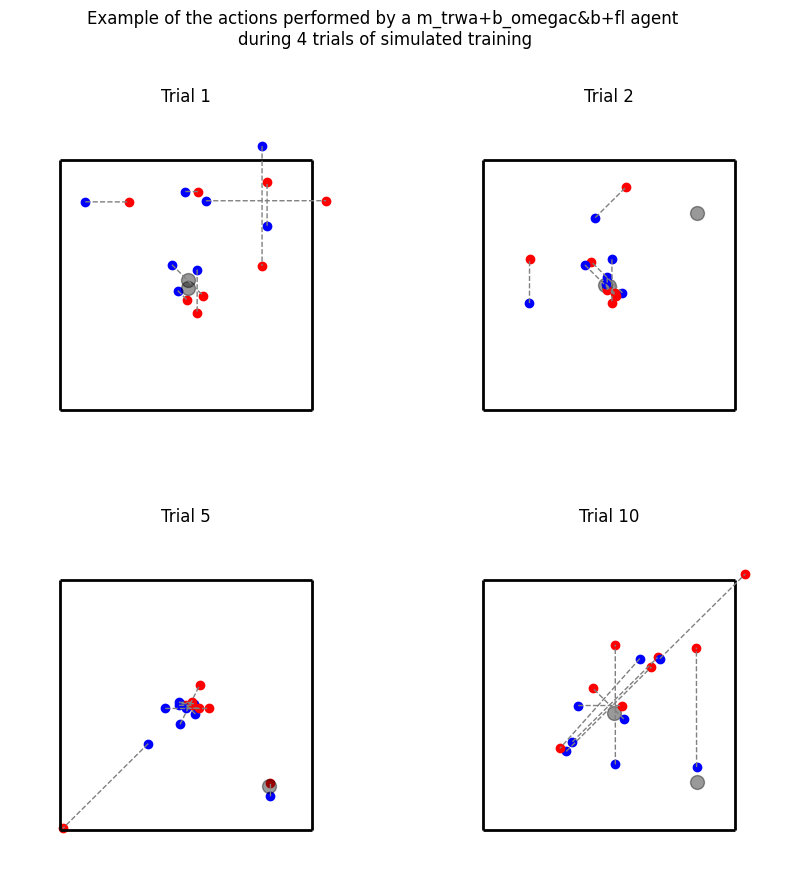

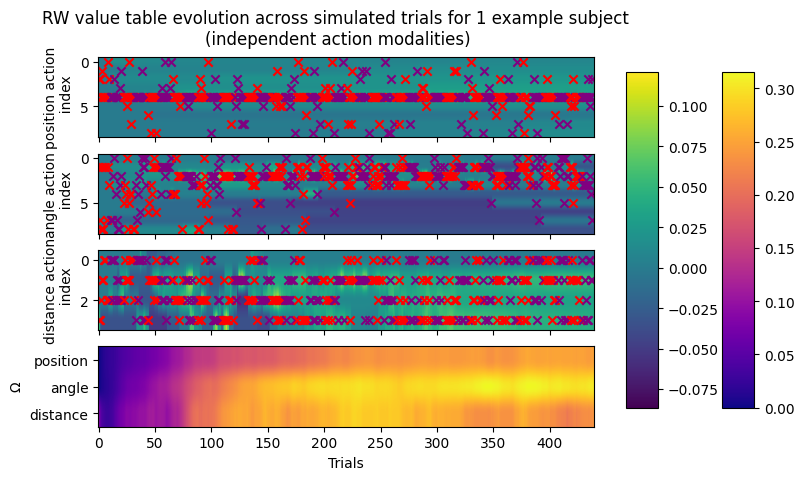

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\simulate\plot_trajectory.py:210: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


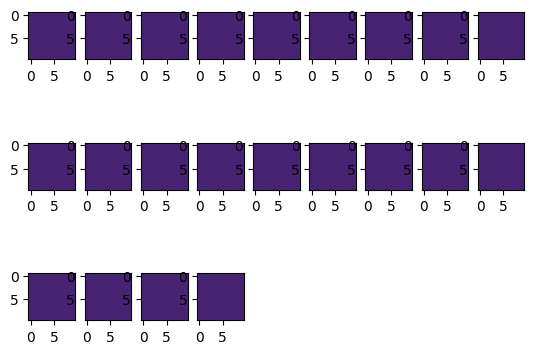

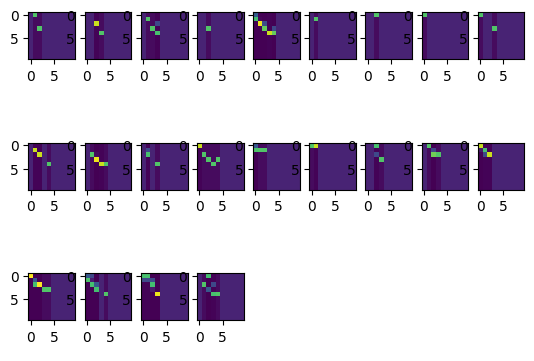

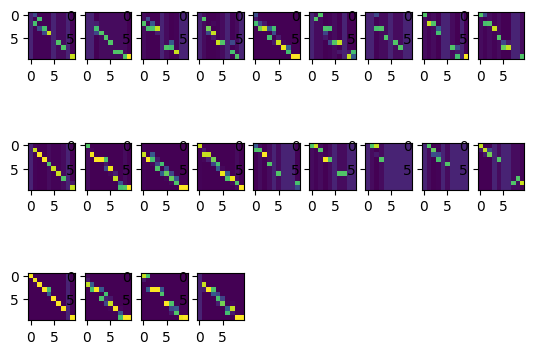

In [ ]:
NTRIALS = 40 # This one takes a while to converge
model_specs = {
    "model_family" : "trw",  # "rw" / "latql" / "tracking_rw"
    "free_parameters" : "mixed",
    "biaises" : ['static'],
    "assymetric_learning_rate" : True,
    "modality_selector" : {
        'learn':True,
        'metric':'js_controll',
        'biaises' : ['initial'],
        'focused_learning' : True,
        'independent_focused_learning_weights' : False
    },
    "generalizer" : False
}       
agent = Agent(model_specs,MODEL_CONSTANTS)
model_hyperparameters = {
    'initial_omega' : jnp.array([0.0,0.0,0.2]),
    'alpha_omega' : 0.4,
    'beta_omega' : 50,
    
    'alpha_Q+': 0.5,
    'alpha_Q-': 0.4, 
    'beta_Q': 80.0,
    'beta_biais' : 30.0,
    'transition_alpha' : 0.7,
    'position':{
        'biais' : jnp.array([0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0])  # The center of the screen is favorized initially
    },
    'angle':{
        'biais' : jnp.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
    },
    'distance':{
        'biais' : jnp.array([0.0,0,0,0])
    },
}  
agent = Agent(model_specs,MODEL_CONSTANTS)
seed = 10



simulated_data = {"feedback":[],"reward":[], "env_state":[]}
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("Example of 9 {} agents simulated training".format(agent.get_name()))
for k,ax in enumerate(axs.reshape(-1)): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)
    
    final_parameters,(environment_variables,agent_variables) = simulate_training(ENVIRONMENT.get_functions(),agent.get_all_functions(model_hyperparameters),
                  jr.PRNGKey(SEED),n_trials=NTRIALS,n_observations_per_trial= ENVIRONMENT.T)
    (_env_states,_env_obs,_env_rewards) = environment_variables
    (_agent_states,_new_params,_agent_actions) = agent_variables

    simulated_states = np.argmax(_env_states,axis=-1)

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)
    
    simulated_data["feedback"].append(_env_obs[0])
    simulated_data["reward"].append(_env_rewards)
    simulated_data["env_state"].append(_env_states)

Ntrials,Ntimesteps,_ =_env_obs[0].shape


obs = np.argmax(np.stack(simulated_data["feedback"]),axis=-1)
scalar_fb = np.reshape(obs/(N_FEEDBACK_OUTCOMES-1),(9,-1))
mean_fb = np.mean(scalar_fb,axis=0)
std_fb = np.std(scalar_fb,axis=0)

gridpoints = jnp.stack(vmap(vmap(vmap(lambda x : ind2sub(GRID_SIZE,x))))(jnp.argmax(jnp.stack(simulated_data["env_state"]),-1)),axis=-1)
maxdist = jnp.linalg.norm(jnp.array(GRID_SIZE))
dtgs = vmap(vmap(vmap(lambda x : jnp.linalg.norm(jnp.array(END_COORD) - x))))(gridpoints)
scalar_dtg = np.reshape(dtgs/maxdist,(9,-1))
mean_dtg = np.mean(scalar_dtg,axis=0)
std_dtg = np.std(scalar_dtg,axis=0)


fig,axs = plt.subplots(2,1,figsize = (6,8),sharex=True)
fig.suptitle("Simulated performances for 9 {} agents".format(agent.get_name()))
axs[0].fill_between(np.arange(mean_fb.shape[0]),mean_fb-std_fb,mean_fb+std_fb,alpha=0.1)
axs[0].plot(np.arange(mean_fb.shape[0]),mean_fb)
for ax in axs:
    ax.set_ylim([0,1])
    ax.grid()
    for trial in range(Ntrials):
        ax.axvline(trial*Ntimesteps,color='red',linestyle="--")
axs[0].set_ylabel("Feedback received")
axs[1].fill_between(np.arange(mean_dtg.shape[0]),mean_dtg-std_dtg,mean_dtg+std_dtg,alpha=0.1)
axs[1].plot(np.arange(mean_dtg.shape[0]),mean_dtg)
for ax in axs:
    for trial in range(Ntrials):
        ax.axvline(trial*Ntimesteps,color='red',linestyle="--")
axs[1].set_xlabel("Trials")
axs[1].set_ylabel("DtG")



# We plot example actions here :
# Because our models are quite simple, we add a little gaussian noise around the sampled values :
Nlines = 2
Ncols = 2
trials =  [0,1,4,9]
fig,axes = plt.subplots(Nlines,Ncols,figsize=(5*Ncols,5*Nlines))
fig.suptitle("Example of the actions performed by a {} agent \nduring {} trials of simulated training".format(agent.get_name(),len(trials)))
# trials = range(axes.flatten().shape[0])
for trial,ax in zip(trials,axes.flatten()):
    ax_title  = ("Trial {}".format(trial+1))
    if trial < Ntrials :
        actions_plotted = {key:val[trial] for (key,val) in _agent_actions.items()}
        plot_actions(ax,actions_plotted,ax_title,'dots',1e-3)
    else :
        ax.axis('off')
plt.show()


# We plot the latent states of interest for this model family here : 
vmin = min([np.min(m) for m in _agent_states["q_table"].values()])
vmax = max([np.max(m) for m in _agent_states["q_table"].values()])

fig,axs = plt.subplots(4,1,sharex=True)
fig.suptitle("RW value table evolution across simulated trials for 1 example subject \n(independent action modalities)")
for k,modality in enumerate(["position","angle","distance"]) : 
    ax = axs[k]
    state_hist = _agent_states["q_table"][modality]
    qtable_state = np.reshape(state_hist,(-1,state_hist.shape[-1]))
    im = ax.imshow(qtable_state.T,aspect=('auto'),vmin = vmin,vmax=vmax)
    ax.set_ylabel("{} action\n  index".format(modality))
    
    
    for trial in range(Ntrials):
        # To differentiate between trials
        if trial % 2 == 0:
            color = 'red'
        else : 
            color = 'purple'
        actions_performed = np.argmax(_agent_actions[modality][trial],axis=-1)
        action_timesteps = Ntimesteps*trial + (np.arange(actions_performed.shape[0]))
        ax.scatter(action_timesteps,actions_performed,marker="x",color=color)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

# fig,ax = plt.subplots(1,1)
# fig.suptitle("RW modality selection table evolution across simulated trials for 1 example subject \n(independent action modalities)")
im2 = axs[-1].imshow(np.reshape(_agent_states['omega'],(-1,3)).T,aspect=('auto'),cmap='plasma')
axs[-1].set_ylabel("$\Omega$")
axs[-1].set_yticks([0,1,2],["position","angle","distance"])


axs[-1].set_xlabel("Trials")
cbar_ax2 = fig.add_axes([1.1, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax2)
plt.show()

for trial in [0,5,-1]:
    plot_learnt_transition_matrix(_agent_states,trial,0)

It seems this regulation mechanism works well but takes a while to kick-in ... Maybe we can gain some time using a latent representation !